In [1]:
import time
import copy
import random
import glob
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.get_device_name())
print(torch.__version__)
print(torch.version.cuda)
x = torch.randn(1).cuda()
print(x)

NVIDIA GeForce GTX 1650
2.1.1
11.8
tensor([0.9383], device='cuda:0')


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
params = {
  'img_size':224,
  'epoch': 10,
  'learning_rate': 0.05,
  'batch_size': 32,
  'seed': 555,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'workers': 3, # 본인 cpu 코어의 절반 정도
  'num_show_img': 5, # 데이터 확인 시 보여줄 데이터 개수
  'momentum': 0.9,
  'weight_decay': 1e-4,
}

In [5]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = params['std'] * input + params['mean']
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

In [20]:
def train_model(model, criterion, optimizer, scheduler, dataloaders: dict, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs), end=": ")
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase =='train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode
      
      running_loss, running_corrects, num_cnt = 0.0, 0, 0

      count = 1
      one_percent = len(dataloders[phase]) * 0.01
      percent = 0.0
      percent_ten = one_percent * 10
      #Iterate over data.
      for inputs, labels in dataloaders[phase]:
        if count > percent:
          if count > percent_ten:
            print("|", end="")
            percent_ten += one_percent * 10
          else:
            print("#", end="")
          percent += one_percent

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        num_cnt += len(labels)
        count += 1
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = float(running_loss / num_cnt)
      epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)
      print()
      print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_idx = epoch
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
  
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print('Best valid Acc: %d 0 %.1f'%(best_idx, best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), 'industrial_model.pt')
  print('model saved')
  return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [21]:
# efficientnet-b0을 from_pretrained 메소드로 기 학습된 모델을 가져온다. (전이학습)
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=5)

random.seed(params['seed']) # 코드 테스트용, 랜덤 시드 고정
torch.manual_seed(params['seed'])

data_path = './S63_DATA1-001'
industrial_dataset = datasets.ImageFolder(
                      data_path,
                      transforms.Compose([
                        transforms.Resize((224, 224)), # efficientnet-b0 이미지 규격에 맞춤
                        transforms.ToTensor(), # 텐서화
                        transforms.Normalize(mean=params['mean'], std=params['std'])
                      ])) # 연구진들이 가장 최적화된 정규화 값을 찾음. 안정된 학습을 위한 데이터 정규화.

224
Loaded pretrained weights for efficientnet-b0


In [22]:
# train : valid : test = 8 : 1 : 1
train_idx, tmp_idx = train_test_split(list(range(len(industrial_dataset))), test_size=0.2, random_state=params['seed'])
data_sets = {}
data_sets['train'] = Subset(industrial_dataset, train_idx)
tmp_dataset = Subset(industrial_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=params['seed'])
data_sets['valid'] = Subset(tmp_dataset, val_idx)
data_sets['test'] = Subset(tmp_dataset, test_idx)

In [23]:
# data loader
dataloders, batch_num = {}, {}
dataloders['train'] = DataLoader(data_sets['train'],
                                  batch_size=params['batch_size'],
                                  shuffle=True,
                                  num_workers=params['workers'])
dataloders['valid'] = DataLoader(data_sets['valid'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
dataloders['test'] = DataLoader(data_sets['test'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloders['train']), len(dataloders['valid']), len(dataloders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (params['batch_size'], batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32,  tvt : 750 / 94 / 94


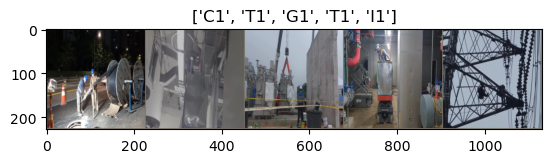

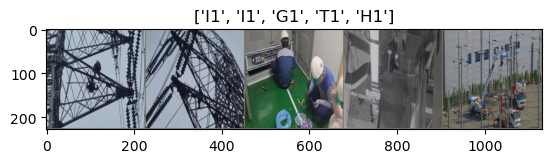

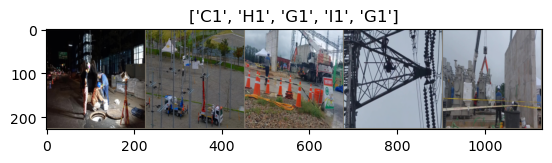

In [24]:
# 데이터 확인
class_names = {
  "0": "C1",
  "1": "G1",
  "2": "H1",
  "3": "I1",
  "4": "T1"
}

# train data
inputs, classes = next(iter(dataloders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

In [25]:
# setting
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(),
                                lr=params['learning_rate'],
                                momentum=params['momentum'],
                                weight_decay=params['weight_decay'])
lmbda = lambda epoch: 0.98739
exp_lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

# CUDA 확인
next(model.parameters()).is_cuda

True

In [26]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloders, num_epochs=params['epoch'])

Epoch 1/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.01 Acc: 99.6
#########|########|#########|########|#########|########|########|#########|########|#########
valid Loss: 0.00 Acc: 100.0
==> best model saved - 0 / 100.0
Epoch 2/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.00 Acc: 100.0
#########|########|#########|########|#########|########|########|#########|########|#########
valid Loss: 0.00 Acc: 100.0
Epoch 3/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.00 Acc: 100.0
#########|########|#########|########|#########|########|########|#########|########|#########
valid Loss: 0.00 Acc: 100.0
Epoch 4/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.00 Ac

best model : 0 - 100 / 0.0


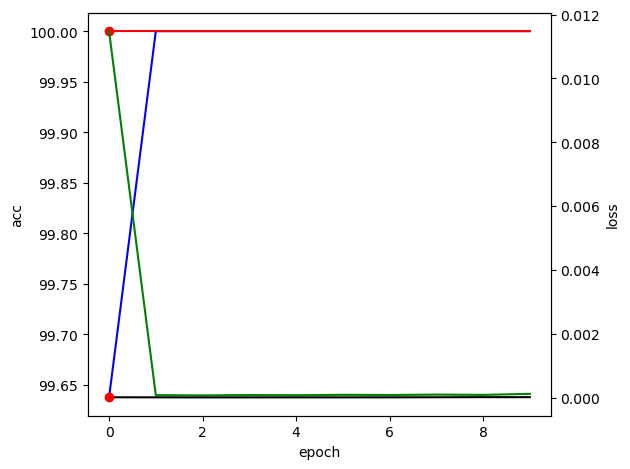

In [29]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()